### measure drift parameters from the Long disk size measurements

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from scipy.optimize import fsolve
%matplotlib inline

/Users/jpw/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [25]:
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble='\\usepackage{xcolor}')

In [3]:
import astropy.constants as c
import astropy.units as u
au = c.au.cgs.value
mH = c.m_p.cgs.value
kB = c.k_B.cgs.value
msun = c.M_sun.cgs.value
G = c.G.cgs.value
mearth = c.M_earth.cgs.value

In [4]:
colnames = ['Source', 'dist', 'lambda', 'Rmm90', 'RCO90', 'Mdust', 'Lstar', 'Teff', 'Mstar', 'age', 'Ref']
df = pd.read_csv('ALL_combined_table.txt', skiprows=2, header=0, sep='\s+', names=colnames)

In [5]:
df

,Source,dist,lambda,Rmm90,RCO90,Mdust,Lstar,Teff,Mstar,age,Ref
0,AS209,121,1.2,127,280,107,1.41,4266,0.83,1.0,Long
1,CIDA1,136,0.9,38,132,7,0.20,3200,0.19,1.0,Long
2,CIDA7,136,0.9,20,95,5,0.08,3111,0.15,2.0,Long
3,CITau,159,1.3,226,520,53,0.81,4277,0.90,2.5,"Semenov,Tripathi"
4,CXTau,128,1.3,29,115,5,0.25,3488,0.38,1.6,Long
5,CYTau,129,1.3,73,295,63,0.25,3560,0.30,2.3,"Semenov,Tripathi"
6,DLTau,159,1.3,145,596,130,0.65,4277,1.05,3.2,Long
7,DMTau,145,1.1,178,876,34,0.14,3415,0.55,3.2,Long
8,DNTau,128,1.3,96,241,43,0.69,3806,0.87,0.9,"Semenov,Tripathi"
9,DoAr25,138,1.2,148,233,119,0.95,4266,0.95,2.0,Long


In [6]:
df.loc[0]

Source    AS209
dist        121
lambda      1.2
Rmm90       127
RCO90       280
Mdust       107
Lstar      1.41
Teff       4266
Mstar      0.83
age         1.0
Ref        Long
Name: 0, dtype: object

In [7]:
# Lynden-Bell & Pringle surface density profile for gamma=1
def sigma1(r, sigma0, rc):
    return sigma0 / (r/rc) / np.exp(r/rc)

def logsigma1(r, sigma0, rc):
    return np.log10(sigma0 / (r/rc) / np.exp(r/rc))

In [8]:
# Powell prescription for the surface density at 1 Myr; all variables in cgs
def powell(v0, rho_s, s, r):
    Myr2seconds = 3.15e13
    Sigma_dust = 2.5 * Myr2seconds * v0 * rho_s * s / r
    return Sigma_dust

In [9]:
# Trapman prescription for the surface density in g/cm2 at the 90% CO radius for a disk with gas+dust mass M
def trapman(M, L):
    logL = np.log10(L)
    #Sigma_CO = 0.0143 * M**0.34
    Sigma_CO = 10**(-2.15-0.53*logL) * M**(0.30-0.08*logL)
    return Sigma_CO

In [10]:
def fitsigma1(R, Sigma):
    # solve equation for gamma=1
    Rc = (R[0]-R[1]) / np.log(Sigma[1]*R[1] / (Sigma[0]*R[0]))
    Sigma0 = Sigma[0] * (R[0] / Rc) * np.exp(R[0]/Rc)
    return Sigma0, Rc

In [11]:
def match_mass(t, R, Sigma, Mdust):
    Sigma_drift = Sigma.copy()
    Sigma_drift[0] *= t
    Sigma0, Rc = fitsigma1(R, Sigma_drift)

    x = np.logspace(0, 3, num=30)
    M = 3.747e-4 * np.trapz(2*np.pi*x*sigma1(x, Sigma0, Rc), x)    # earth masses of dust (for g/d=100)

    return M-Mdust

In [12]:
def toomre(t, R, Sigma, Mstar, Lstar):
    Sigma_drift = Sigma.copy()
    Sigma_drift[0] *= t
    Sigma0, Rc = fitsigma1(R, Sigma_drift)

    x = np.logspace(0, 3, num=30)
    T0 = 82 * (Lstar/0.28)**(2/7) / (Mstar/0.8)**(1/7) 
    T = T0 * x**(-3/7)
    c_s = 5952 * np.sqrt(T)
    Omega = 1.99e-7 * np.sqrt(Mstar / x**3)
    Q = 4.77e6 * c_s * Omega / sigma1(x, Sigma0, Rc)
    Qmin = np.min(Q)

    return Qmin-1

In [13]:
def mq(R, Sigma0, Rc, Mstar, Lstar):
    # calculate the total mass and Toomre Q profile over R in au
    Sigma_fit = sigma1(R, Sigma0, Rc)

    # integrate Sigma to get total mass
    M = 1.125e-7 * np.trapz(Sigma_fit*2*np.pi*R, R)    # solar masses

    T0 = 82 * (Lstar/0.28)**(2/7) / (Mstar/0.8)**(1/7) 
    T = T0 * R**(-3/7)
    c_s = 5952 * np.sqrt(T)
    Omega = 1.99e-7 * np.sqrt(Mstar / R**3)
    Q = 4.77e6 * c_s * Omega / Sigma_fit

    return M, Q

In [14]:
def get_data_points(df, iloc):
    Mstar = df['Mstar'][iloc]                           # Msun
    Lstar = df['Lstar'][iloc]                           # Lsun
    T0 = 82 * (Lstar/0.28)**(2/7) / (Mstar/0.8)**(1/7)  # midplane temperature at 1au Powell 2017 equation 2
    #print(T0)
    rho_s = 2.0                                         # g/cm^3
    s = df['lambda'][iloc] / (20*np.pi)                 # grain size in cm

    # dust and CO radii in au
    R_obs = np.array([df['Rmm90'][iloc], df['RCO90'][iloc]])

    # drift speed in cm/s
    T = T0 * (R_obs[0])**(-3/7)
    c_s = np.sqrt(kB * T / (2.33 * mH))
    v_k = np.sqrt(G * Mstar * msun / (R_obs[0] * au))
    v0 = c_s**2 / (2 * v_k)
    print(f'Drift speed = {v0/1e5:5.3f} km/s')

    # dust mass assuming Tdust=20K, in earth masses
    # disk mass for gas/dust=100, in solar masses
    Mdust = df['Mdust'][iloc]
    Mdisk = 100 * Mdust * mearth/msun
    print(f'Dust mass ={Mdust:6.2f} earth masses, total disk mass ={Mdisk:6.4f} solar masses')

    # surface density for dust at 1 Myr and CO at given Mdisk
    Sigma = np.array([powell(v0, rho_s, s, R_obs[0]*au), trapman(Mdisk, Lstar)])

    return(R_obs, Sigma, Mdust)

In [85]:
def fit_data(df, iloc, plot_to_screen=True, panelplot=False, ax=None):
    source = df['Source'][iloc]
    print(f'Source: {source}')
    Mstar = df['Mstar'][iloc]
    Lstar = df['Lstar'][iloc]
    tstar = df['age'][iloc]
    R_obs, Sigma, Mdust = get_data_points(df, iloc)

    if plot_to_screen:
        plt.ion()
    else:
        plt.ioff()

    if panelplot:
        fontsize = 15
    else:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
        fontsize = 16

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(2, 1e3)
    ax.set_ylim(7e-4, 1e3)

    ax2 = ax.twinx()
    ax2.set_yscale('log')
    ax2.set_ylim(0.1, 100)
    ax2.plot([0, 1e3], [1, 1], ':', lw=3, alpha=0.5, color='black')

    if not panelplot:
        ax.set_xlabel('r (au)', fontsize=fontsize)
        ax.set_ylabel(r'$\Sigma_{\rm gas}$ (g cm$^{-2}$)', fontsize=fontsize)
        ax2.set_ylabel('Toomre Q', fontsize=fontsize)
        #ax.grid(which='both', alpha=0.3, ls='--') 

    # make main axis visible above second without hiding it
    ax.set_zorder(1)
    ax.patch.set_visible(False)

    R_plot = np.logspace(0, 3, num=30)
    M_fit = []
    max_iter = 10

    # initial guesses for drif time and max stable disk mass
    t0 = 1.0
    mdisk0 = 0.1
    # some disks need different starting conditions to converge
    if source in ['DoAr25', 'FPTau']:
        t0 = 0.1
        mdisk0 = 0.01
    if source in ['IQTau', 'Sz129', 'Sz71', 'Sz98']:
        t0 = 0.5
        mdisk0 = 0.2
    if source == 'HD143006':
        t0 = 1
        mdisk0 = 0.3
    if source == 'J04202555+2700355':
        t0 = 0.01
        mdisk0 = 0.01
    if source == 'J11004022–7619280':
        t0 = 0.1
        mdisk0 = 0.01
    if source == 'TWHya':
        t0 = 2
        mdisk0 = 0.2

    # solve for the two extreme cases
    for i in range(2):
        if i == 0:
            # disk mass = 100 * dust mass
            label = 'Case 1'
            color = 'blue'
            #label = str(f"100M_dust = {100*Mdust*mearth/msun:6.3f}")
            #label = str(f"$M = {100*Mdust*mearth/msun:6.3f} M_\odot$")
            t_drift = fsolve(match_mass, t0, args=(R_obs, Sigma, Mdust))[0]
            td0 = t_drift
        if i == 1:
            # disk is marginally gravitationally stable
            color = 'red'
            label = 'Case 2'
            iter = 0
            mdisk_converge = False
            while iter < max_iter and not mdisk_converge:
                Sigma_iter = Sigma.copy()
                Sigma_iter[1] = trapman(mdisk0, Lstar)
                t_drift = fsolve(toomre, t0, args=(R_obs, Sigma_iter, Mstar, Lstar))[0]
                Sigma_iter[0] *= t_drift
                Sigma0, Rc = fitsigma1(R_obs, Sigma_iter)
                Sigma_fit = sigma1(R_plot, Sigma0, Rc)
                mdisk1 = 1.125e-7 * np.trapz(Sigma_fit*2*np.pi*R_plot, R_plot)
                print(f'Trapman iteration {iter}: t_drift={t_drift:6.3f}   Mass change {mdisk0:6.3f} --> {mdisk1:6.3f}')
                if np.abs(mdisk1/mdisk0-1) <  0.99:
                    mdisk_converge = True
                mdisk0 = mdisk1
                iter += 1
            #label = str(f"M(Q=1) = {mdisk0:6.3f}")
            #label = str(f"$M = {mdisk0:6.3f} M_\odot$")
        Sigma_drift = Sigma.copy()
        Sigma_drift[0] *= t_drift
        td1 = t_drift
        if i==1:
            Sigma_drift[1] = trapman(mdisk0, Lstar)

        ax.plot(R_obs, Sigma_drift, 'o', color=color, label=label)
        Sigma0, Rc = fitsigma1(R_obs, Sigma_drift)
        M, Q = mq(R_plot, Sigma0, Rc, Mstar, Lstar)
        M_fit.append(M)

        Sigma_plot = sigma1(R_plot, Sigma0, Rc)
        tau1 = Sigma_plot > 50
        ax.plot(R_plot, Sigma_plot, '-', color=color)
        ax.plot(R_plot[tau1], Sigma_plot[tau1], '-', color=color, lw=3)
        ax2.plot(R_plot, Q, '--', color=color, zorder=0)
        ax.legend(fontsize=fontsize-6)

        print(f'tdrift ={t_drift:6.3f} Myr, M = {M:6.4f} solar masses, Qmin = {np.min(Q):5.2f}')

    rect = patches.Rectangle((0.02, 0.02), 0.26, 0.22, edgecolor='None', facecolor='white', alpha=0.8, transform=ax.transAxes, zorder=2)
    ax.add_patch(rect)
    ax.text(0.03, 0.17, source, fontsize=fontsize, ha='left', transform=ax.transAxes, zorder=3)
    ax.text(0.03, 0.125, f'Stellar age = {tstar:4.1f} Myr', fontsize=fontsize-4, ha='left', transform=ax.transAxes, zorder=3)
    #ax.text(0.03, 0.04, f'Drift times = {td0:3.1f}-{td1:3.1f} Myr', fontsize=fontsize-4, ha='left', transform=ax.transAxes, zorder=3)

    M1str = str(f"{100*Mdust*mearth/msun:6.3f}")
    t1str = str(f"{td0:4.1f}")
    #ax.text(0.03, 0.08, "Case 1: $M=100M_{dust}=$"+M1str+"$M_\odot, t_{drift}=$"+t1str+" Myr", color='blue', fontsize=fontsize-5, ha='left', transform=ax.transAxes, zorder=3)
    ax.text(0.03, 0.08, "Case 1: $M=$"+M1str+"$M_\odot, t_{drift}=$"+t1str+" Myr", color='blue', fontsize=fontsize-5, ha='left', transform=ax.transAxes, zorder=3)
    M2str = str(f"{mdisk0:6.3f}")
    t2str = str(f"{td1:4.1f}")
    #ax.text(0.03, 0.04, "Case 2: $M(Q_{min}=1)=$"+M2str+"$M_\odot, t_{drift}=$"+t2str+" Myr", color='red', fontsize=fontsize-5, ha='left', transform=ax.transAxes, zorder=3)
    ax.text(0.03, 0.04, "Case 2: $M=$"+M2str+"$M_\odot, t_{drift}=$"+t2str+" Myr", color='red', fontsize=fontsize-5, ha='left', transform=ax.transAxes, zorder=3)

    if not panelplot:
        fig.tight_layout()
        fig.savefig(source+'.pdf')

    if not plot_to_screen:
        plt.close()

    return td0, td1, *M_fit

Source: AS209
Drift speed = 0.012 km/s
Dust mass =107.00 earth masses, total disk mass =0.0321 solar masses
tdrift = 0.165 Myr, M = 0.0321 solar masses, Qmin =  9.22
Trapman iteration 0: t_drift= 0.708   Mass change  0.100 -->  0.275
Trapman iteration 1: t_drift= 0.796   Mass change  0.275 -->  0.277
tdrift = 0.796 Myr, M = 0.2768 solar masses, Qmin =  1.00


(0.16498183130540198,
 0.7964716141621364,
 0.03212570056044957,
 0.2768096420083713)

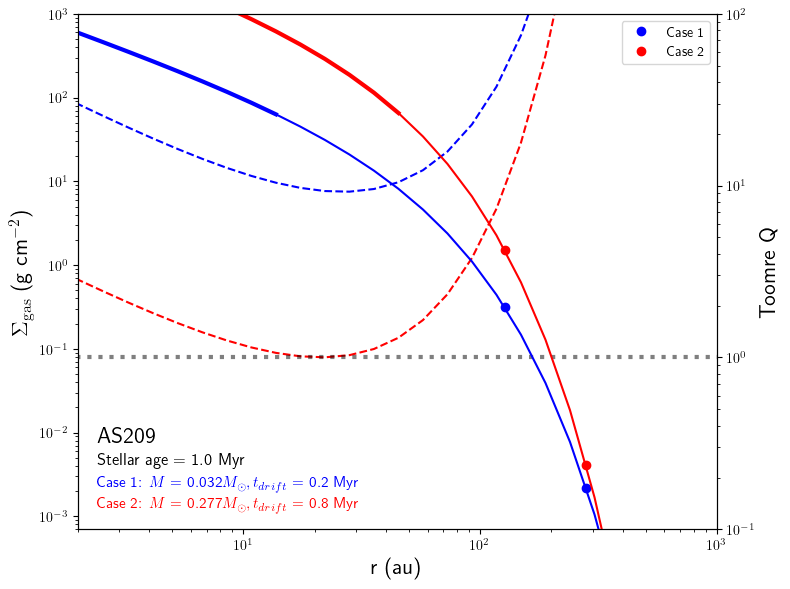

In [86]:
fit_data(df, 0, plot_to_screen=True)

In [87]:
# DO ALL SOURCES!
f = open('drift_fit_results.txt', 'w')
f.write("#Source             Age  Drift_min Drift_max  M_min   M_max\n")
f.write("#-----------------------------------------------------------\n")
for i in range(len(df)):
    td_min, td_max, M_min, M_max = fit_data(df, i, plot_to_screen=False)
    f.write(f"{df['Source'][i]:17s} {(df['age'][i]):4.1f}  {td_min:6.3f}     {td_max:6.3f}  {M_min:7.4f} {M_max:7.4f}\n")
f.close()

Source: AS209
Drift speed = 0.012 km/s
Dust mass =107.00 earth masses, total disk mass =0.0321 solar masses
tdrift = 0.165 Myr, M = 0.0321 solar masses, Qmin =  9.22
Trapman iteration 0: t_drift= 0.708   Mass change  0.100 -->  0.275
Trapman iteration 1: t_drift= 0.796   Mass change  0.275 -->  0.277
tdrift = 0.796 Myr, M = 0.2768 solar masses, Qmin =  1.00
Source: CIDA1
Drift speed = 0.016 km/s
Dust mass =  7.00 earth masses, total disk mass =0.0021 solar masses
tdrift = 0.097 Myr, M = 0.0021 solar masses, Qmin = 47.03
Trapman iteration 0: t_drift= 2.677   Mass change  0.100 -->  0.087
tdrift = 2.677 Myr, M = 0.0885 solar masses, Qmin =  0.99
Source: CIDA7
Drift speed = 0.014 km/s
Dust mass =  5.00 earth masses, total disk mass =0.0015 solar masses
tdrift = 0.186 Myr, M = 0.0015 solar masses, Qmin = 46.07
Trapman iteration 0: t_drift= 6.456   Mass change  0.100 -->  0.062
tdrift = 6.456 Myr, M = 0.0632 solar masses, Qmin =  0.97
Source: CITau
Drift speed = 0.010 km/s
Dust mass = 53.00

In [89]:
# PANEL PLOT
fig = plt.figure(figsize=(24, 20))
df_indices = range(1,21)
#df_indices = range(21,41)
ny = 5
nx = 4
for nplot, iloc in enumerate(df_indices):
    ax = fig.add_subplot(ny, nx, nplot+1)
    ax2 = ax.twinx()
    ax2.set_yticks([])
    #ax2.set_yscale('log')
    #ax2.set_ylim(0.1, 100)
    td_min, td_max, M_min, M_max = fit_data(df, iloc, plot_to_screen=False, panelplot=True, ax=ax)
    if nplot in [16, 17, 18, 19]:
        ax.set_xlabel('r (au)', fontsize=16)
    if nplot in [0, 4, 8, 12, 16]:
        ax.set_ylabel(r'$\Sigma_{\rm gas}$ (g cm$^{-2}$)', fontsize=16)
    if nplot in [3, 7, 11, 15, 19]:
        ax2.yaxis.set_label_coords(1.08,0.0)
        ax2.set_ylabel('Toomre Q', fontsize=16)

fig.tight_layout()
fig.savefig('panelplot.pdf', dpi=600)

Source: CIDA1
Drift speed = 0.016 km/s
Dust mass =  7.00 earth masses, total disk mass =0.0021 solar masses
tdrift = 0.097 Myr, M = 0.0021 solar masses, Qmin = 47.03
Trapman iteration 0: t_drift= 2.677   Mass change  0.100 -->  0.087
tdrift = 2.677 Myr, M = 0.0885 solar masses, Qmin =  0.99
Source: CIDA7
Drift speed = 0.014 km/s
Dust mass =  5.00 earth masses, total disk mass =0.0015 solar masses
tdrift = 0.186 Myr, M = 0.0015 solar masses, Qmin = 46.07
Trapman iteration 0: t_drift= 6.456   Mass change  0.100 -->  0.062
tdrift = 6.456 Myr, M = 0.0632 solar masses, Qmin =  0.97
Source: CITau
Drift speed = 0.010 km/s
Dust mass = 53.00 earth masses, total disk mass =0.0159 solar masses
tdrift = 0.105 Myr, M = 0.0159 solar masses, Qmin = 23.97
Trapman iteration 0: t_drift= 0.962   Mass change  0.100 -->  0.334
Trapman iteration 1: t_drift= 1.108   Mass change  0.334 -->  0.340
tdrift = 1.108 Myr, M = 0.3389 solar masses, Qmin =  1.00
Source: CXTau
Drift speed = 0.011 km/s
Dust mass =  5.00